# Description
Trains a stacked what-where autoencoder built on residual blocks on the
MNIST dataset. It exemplifies two influential methods that have been developed
in the past few years.

The first is the idea of properly 'unpooling.' During any max pool, the
exact location (the 'where') of the maximal value in a pooled receptive field
is lost, however it can be very useful in the overall reconstruction of an
input image. Therefore, if the 'where' is handed from the encoder
to the corresponding decoder layer, features being decoded can be 'placed' in
the right location, allowing for reconstructions of much higher fidelity.

## References

- Visualizing and Understanding Convolutional Networks
  Matthew D Zeiler, Rob Fergus
  https://arxiv.org/abs/1311.2901v3
- Stacked What-Where Auto-encoders
  Junbo Zhao, Michael Mathieu, Ross Goroshin, Yann LeCun
  https://arxiv.org/abs/1506.02351v8

The second idea exploited here is that of residual learning. Residual blocks
ease the training process by allowing skip connections that give the network
the ability to be as linear (or non-linear) as the data sees fit.  This allows
for much deep networks to be easily trained. The residual element seems to
be advantageous in the context of this example as it allows a nice symmetry
between the encoder and decoder. Normally, in the decoder, the final
projection to the space where the image is reconstructed is linear, however
this does not have to be the case for a residual block as the degree to which
its output is linear or non-linear is determined by the data it is fed.
However, in order to cap the reconstruction in this example, a hard softmax is
applied as a bias because we know the MNIST digits are mapped to [0, 1].

## References
- Deep Residual Learning for Image Recognition
  Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
  https://arxiv.org/abs/1512.03385v1
- Identity Mappings in Deep Residual Networks
  Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
  https://arxiv.org/abs/1603.05027v3

In [2]:
from __future__ import print_function
import numpy as np

from keras.datasets import mnist
from keras.models import Model
from keras.layers import Activation
from keras.layers import UpSampling2D, Conv2D, MaxPooling2D
from keras.layers import Input, BatchNormalization, ELU
import matplotlib.pyplot as plt
import keras.backend as K
from keras import layers


def convresblock(x, nfeats=8, ksize=3, nskipped=2, elu=True):
    """The proposed residual block from [4].

    Running with elu=True will use ELU nonlinearity and running with
    elu=False will use BatchNorm + RELU nonlinearity.  While ELU's are fast
    due to the fact they do not suffer from BatchNorm overhead, they may
    overfit because they do not offer the stochastic element of the batch
    formation process of BatchNorm, which acts as a good regularizer.

    # Arguments
        x: 4D tensor, the tensor to feed through the block
        nfeats: Integer, number of feature maps for conv layers.
        ksize: Integer, width and height of conv kernels in first convolution.
        nskipped: Integer, number of conv layers for the residual function.
        elu: Boolean, whether to use ELU or BN+RELU.

    # Input shape
        4D tensor with shape:
        `(batch, channels, rows, cols)`

    # Output shape
        4D tensor with shape:
        `(batch, filters, rows, cols)`
    """
    y0 = Conv2D(nfeats, ksize, padding='same')(x)
    y = y0
    for i in range(nskipped):
        if elu:
            y = ELU()(y)
        else:
            y = BatchNormalization(axis=1)(y)
            y = Activation('relu')(y)
        y = Conv2D(nfeats, 1, padding='same')(y)
    return layers.add([y0, y])


def getwhere(x):
    ''' Calculate the 'where' mask that contains switches indicating which
    index contained the max value when MaxPool2D was applied.  Using the
    gradient of the sum is a nice trick to keep everything high level.'''
    y_prepool, y_postpool = x
    return K.gradients(K.sum(y_postpool), y_prepool)

if K.backend() == 'tensorflow':
    raise RuntimeError('This example can only run with the '
                       'Theano backend for the time being, '
                       'because it requires taking the gradient '
                       'of a gradient, which isn\'t '
                       'supported for all TensorFlow ops.')

Using Theano backend.


x_train shape: (60000, 1, 28, 28)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 259s 4ms/step - loss: 0.0138 - val_loss: 0.0044
Epoch 2/5
60000/60000 [==============================] - 251s 4ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 3/5
60000/60000 [==============================] - 319s 5ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/5
60000/60000 [==============================] - 317s 5ms/step - loss: 0.0025 - val_loss: 0.0023
Epoch 5/5
60000/60000 [==============================] - 300s 5ms/step - loss: 0.0022 - val_loss: 0.0021


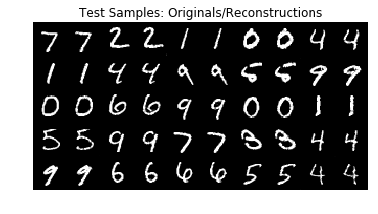

In [3]:
# This example assume 'channels_first' data format.
K.set_image_data_format('channels_first')

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# The size of the kernel used for the MaxPooling2D
pool_size = 2
# The total number of feature maps at each layer
nfeats = [8, 16, 32, 64, 128]
# The sizes of the pooling kernel at each layer
pool_sizes = np.array([1, 1, 1, 1, 1]) * pool_size
# The convolution kernel size
ksize = 3
# Number of epochs to train for
epochs = 5
# Batch size during training
batch_size = 128

if pool_size == 2:
    # if using a 5 layer net of pool_size = 2
    x_train = np.pad(x_train, [[0, 0], [0, 0], [2, 2], [2, 2]],
                     mode='constant')
    x_test = np.pad(x_test, [[0, 0], [0, 0], [2, 2], [2, 2]], mode='constant')
    nlayers = 5
elif pool_size == 3:
    # if using a 3 layer net of pool_size = 3
    x_train = x_train[:, :, :-1, :-1]
    x_test = x_test[:, :, :-1, :-1]
    nlayers = 3
else:
    import sys
    sys.exit('Script supports pool_size of 2 and 3.')

# Shape of input to train on (note that model is fully convolutional however)
input_shape = x_train.shape[1:]
# The final list of the size of axis=1 for all layers, including input
nfeats_all = [input_shape[0]] + nfeats

# First build the encoder, all the while keeping track of the 'where' masks
img_input = Input(shape=input_shape)

# We push the 'where' masks to the following list
wheres = [None] * nlayers
y = img_input
for i in range(nlayers):
    y_prepool = convresblock(y, nfeats=nfeats_all[i + 1], ksize=ksize)
    y = MaxPooling2D(pool_size=(pool_sizes[i], pool_sizes[i]))(y_prepool)
    wheres[i] = layers.Lambda(
        getwhere, output_shape=lambda x: x[0])([y_prepool, y])

# Now build the decoder, and use the stored 'where' masks to place the features
for i in range(nlayers):
    ind = nlayers - 1 - i
    y = UpSampling2D(size=(pool_sizes[ind], pool_sizes[ind]))(y)
    y = layers.multiply([y, wheres[ind]])
    y = convresblock(y, nfeats=nfeats_all[ind], ksize=ksize)

# Use hard_simgoid to clip range of reconstruction
y = Activation('hard_sigmoid')(y)

# Define the model and it's mean square error loss, and compile it with Adam
model = Model(img_input, y)
model.compile('adam', 'mse')

# Fit the model
model.fit(x_train, x_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, x_test))

# Plot
x_recon = model.predict(x_test[:25])
x_plot = np.concatenate((x_test[:25], x_recon), axis=1)
x_plot = x_plot.reshape((5, 10, input_shape[-2], input_shape[-1]))
x_plot = np.vstack([np.hstack(x) for x in x_plot])
plt.figure()
plt.axis('off')
plt.title('Test Samples: Originals/Reconstructions')
plt.imshow(x_plot, interpolation='none', cmap='gray')
plt.savefig('reconstructions.png')